# Define custom image transforms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
from glob import glob
from pathlib import Path
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.transforms as _transforms
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Transform
from torchvision.utils import make_grid

from src.modules.images.timm_pretrained import CNNEncoder
from src.modules.transforms import ComplexTransform, NormalizeBeforeCrop, SimpleTransform, SimpleWithNormalize
from src.modules.transforms.color_jitter import ColorJitterPerChannel
from src.modules.transforms.drop_channel import DropTransform
from src.modules.transforms.fill_nans import FillNaNs
from src.modules.transforms.image_normalization import ImageNormalization
from src.utils.io import load_image_paths_to_array

plt.rcParams["savefig.bbox"] = "tight"

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Plea

In [3]:
def show(imgs, figsize=(10, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
for i in range(1, 4):
    if not Path(f"../cpjump{i}/jump/").exists():
        print(f"Mounting cpjump{i}...")
        os.system(f"sshfs bioclust:/projects/cpjump{i}/ ../cpjump{i}")
    else:
        print(f"cpjump{i} already mounted.")

Mounting cpjump1...
Mounting cpjump2...
Mounting cpjump3...


In [5]:
image_path = "../cpjump1/jump/images/source_9/20210831-Run7/GR00003330"

In [6]:
default_channels = ["DNA", "AGP", "ER", "Mito", "RNA"]

In [7]:
possible_files = glob(f"{image_path}/*DNA.png")

In [8]:
class SimpleDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.possible_files = glob(f"{image_path}/*DNA.png")
        self.channels = ["DNA", "AGP", "ER", "Mito", "RNA"]
        self.transform = transform

    def __len__(self):
        return len(self.possible_files)

    def __getitem__(self, index):
        base_path = self.possible_files[index]

        image_paths = [base_path.replace("DNA", channel) for channel in self.channels]

        imgs = [np.array(Image.open(image_path)) for image_path in image_paths]
        img_array = np.stack(imgs)
        img_array = torch.from_numpy(img_array)

        if self.transform:
            img_array = self.transform(img_array)

        return img_array

In [335]:
class Simple(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop(size, pad_if_needed=True),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Gaussian(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop(size, pad_if_needed=True),
                transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class RandomResize(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Color(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.5, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Total(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomOrder(
                    [
                        transforms.RandomHorizontalFlip(p=0.3),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                        transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.0, hue=0.0),
                    ]
                ),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Drop1(transforms.Compose):
    def __init__(self, size=256, p=0.1):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                DropTransform(p=p),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


class Drop(transforms.Compose):
    def __init__(self, size=256):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                transforms.RandomOrder(
                    [
                        transforms.RandomHorizontalFlip(p=0.3),
                        transforms.RandomVerticalFlip(p=0.3),
                        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
                        transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.0, hue=0.0),
                        DropTransform(p=0.1),
                    ]
                ),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )


def adjust_intensity(image, intensity=0.3):
    intensity_born = [-intensity, intensity]
    intensity_factor = torch.empty(1).uniform_(*intensity_born).to(image.device)

    output = image + intensity_factor
    return output


def adjust_brightness(image, brightness=0.5):
    brightness_born = [max(1 - brightness, 0.0), 1 + brightness]
    brightness_factor = torch.empty(1).uniform_(*brightness_born).to(image.device)

    output = image.pow(brightness_factor).clamp_(0, 1)
    return output


class Color2(transforms.Compose):
    def __init__(self, size=256, intensity=0.3, brightness=0.5):
        super().__init__(
            (
                transforms.ToImageTensor(),
                transforms.ConvertImageDtype(),
                ColorJitterPerChannel(intensity=intensity, brightness=brightness),
                transforms.RandomResizedCrop(size=size, scale=(size / 768, 1.0), ratio=(1.0, 1.0), interpolation=2),
                FillNaNs(nan=0.0, posinf=None, neginf=None),
            )
        )

In [350]:
T = transforms

In [362]:
ComplexTransform(sigma=(1, 3))

ComplexTransform(
      ToImageTensor()
      ConvertDtype()
      RandomHorizontalFlip(p=0.3)
      RandomVerticalFlip(p=0.3)
      RandomOrder(transforms=[RandomApply(    GaussianBlur(kernel_size=(23, 23), sigma=(1.0, 3.0))), RandomApply(    ColorJitterPerChannel(intensity=0.3, brightness=0.5))])
      DropTransform(p=0.3)
      RandomResizedCrop(size=(256, 256), scale=(0.3333333333333333, 1.0), ratio=(1.0, 1.0), interpolation=InterpolationMode.BILINEAR, antialias=warn)
      FillNaNs()
)

In [391]:
tranfs = [
    Simple(size=512),
    # Gaussian(size=512),
    RandomResize(size=512),
    # Color(size=512),
    # Total(size=512),
    # Drop1(size=512, p=0.8),
    # Drop(size=512),
    Color2(size=512, intensity=0.3, brightness=0.5),
    ComplexTransform(size=512, sigma=(1, 3), fill_nan=False),
]

In [382]:
logging.basicConfig(level=logging.INFO)

In [78]:
dataset = SimpleDataset(image_path, transform=None)
loader = DataLoader(dataset, batch_size=4, shuffle=False)

In [184]:
b = next(iter(loader))

In [364]:
chan = b[:, :, :, :].clone()

In [383]:
img = []

for trans in tranfs:
    chan_clone = chan.clone()
    sub = []
    for ch in range(chan_clone.shape[0]):
        sub.append(trans(chan_clone[ch]))

    img.append(torch.stack(sub))

img = torch.cat(img, dim=0)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
INFO:src.modules.transforms.fill_nans:Inpt tensor has NaNs. Fill with 0.0.
INFO:src.modules.transforms.fill_nans:Inpt tensor has NaNs. Fill with 0.0.
INFO:src.modules.transforms.fill_nans:Inpt tensor has NaNs. Fill with 0.0.


In [395]:
complex = tranfs[-1]

In [419]:
transforms = [
    T.ToImageTensor(),
    T.ConvertImageDtype(),
]
sigma = (1.0, 3.0)

transforms.append(T.RandomHorizontalFlip(p=0.3))
transforms.append(T.RandomVerticalFlip(p=0.3))

sub_transforms = []
sub_transforms.append(T.RandomApply([T.GaussianBlur(kernel_size=23, sigma=sigma)], p=0.8))

sub_transforms.append(T.RandomApply([ColorJitterPerChannel(intensity=0.3, brightness=0.5)], p=0.8))

transforms.append(T.RandomOrder(sub_transforms))

transforms.append(T.RandomResizedCrop(size=512, scale=(512 / 768, 1.0), ratio=(1.0, 1.0), interpolation=2))

transforms.append(DropTransform(p=0.3))

transforms.append(FillNaNs(nan=0.0, posinf=None, neginf=None))

In [410]:
single = chan[0]

In [421]:
trans_single = single.clone()
for trans in transforms:
    trans_single = trans(trans_single)
    print(trans, torch.isnan(trans_single).any())
    if torch.isnan(trans_single).any():
        break

ToImageTensor() tensor(False)
ConvertDtype() tensor(False)
RandomHorizontalFlip(p=0.3) tensor(False)
RandomVerticalFlip(p=0.3) tensor(False)
RandomOrder(transforms=[RandomApply(    GaussianBlur(kernel_size=(23, 23), sigma=(1.0, 3.0))), RandomApply(    ColorJitterPerChannel(intensity=0.3, brightness=0.5))]) tensor(True)


In [392]:
chan_clone = chan.clone()
sub = []
for ch in range(chan_clone.shape[0]):
    sub.append(tranfs[-1](chan_clone[ch]))

res = torch.stack(sub)

/home/gwatk/miniconda3/envs/jump_models/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [394]:
res

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2518e-01,
           1.7028e-01, 1.1353e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2643e-01,
           9.2846e-02, 6.2132e-02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.1791e-02,
           4.6931e-02, 3.4316e-02],
          ...,
          [1.1470e-02, 1.0894e-02, 1.0816e-02,  ..., 1.7660e-02,
           1.8787e-02, 1.9693e-02],
          [1.2358e-02, 1.1964e-02, 1.1911e-02,  ..., 1.7892e-02,
           1.9049e-02, 1.9893e-02],
          [1.3766e-02, 1.3538e-02, 1.3526e-02,  ..., 1.8280e-02,
           1.9290e-02, 2.0013e-02]],

         [[2.3204e-02, 2.0963e-02, 2.5181e-02,  ..., 2.1642e-01,
           2.0512e-01, 1.8931e-01],
          [2.0496e-02, 2.0122e-02, 2.5971e-02,  ..., 2.0390e-01,
           2.0069e-01, 1.9273e-01],
          [1.7380e-02, 1.8683e-02, 2.5837e-02,  ..., 1.8927e-01,
           1.8945e-01, 1.8695e-01],
          ...,
          [7.4580e-02, 8.3804e-02, 9.2563e-02,  ..., 1.6548

In [393]:
res[0][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2252, 0.1703, 0.1135],
        [0.0000, 0.0000, 0.0000,  ..., 0.1264, 0.0928, 0.0621],
        [0.0000, 0.0000, 0.0000,  ..., 0.0618, 0.0469, 0.0343],
        ...,
        [0.0115, 0.0109, 0.0108,  ..., 0.0177, 0.0188, 0.0197],
        [0.0124, 0.0120, 0.0119,  ..., 0.0179, 0.0190, 0.0199],
        [0.0138, 0.0135, 0.0135,  ..., 0.0183, 0.0193, 0.0200]])

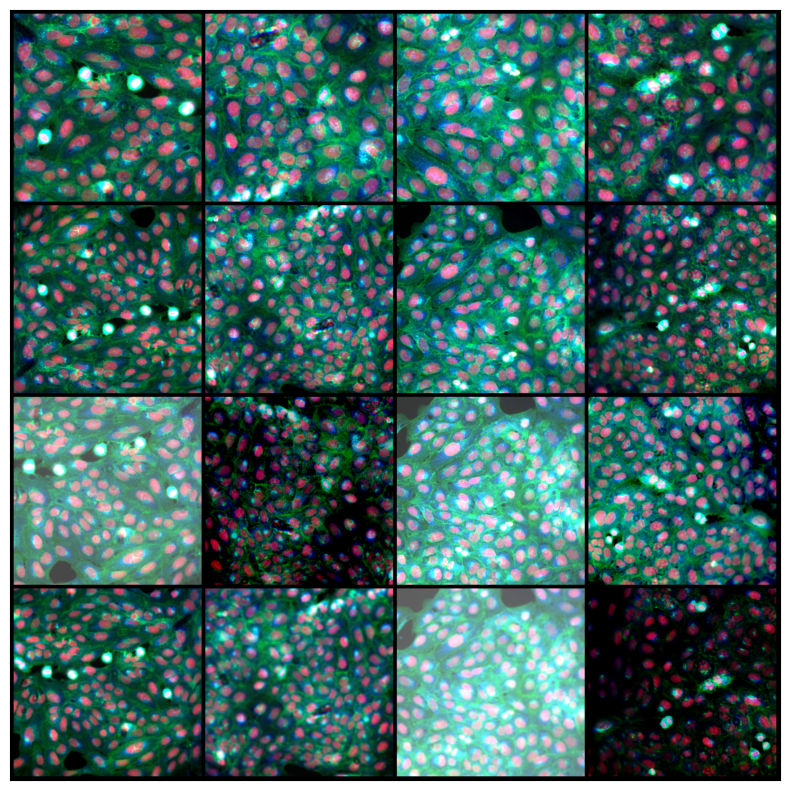

In [381]:
grid = make_grid(
    img[:, :3],
    figsize=(14, 14),
    nrow=4,
    padding=10,
    pad_value=0,
)
show(grid)

In [195]:
grid.shape

torch.Size([3, 3600, 2058])

In [15]:
dataset = SimpleDataset(image_path, transform=trans5)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [16]:
for batch in loader:
    print(batch.shape)
    break

torch.Size([4, 5, 512, 512])


In [15]:
img_encoder = CNNEncoder(
    instance_model_name="vit_base_r50_s16_384",
    target_num=512,
    n_channels=5,
)

In [26]:
img_encoder.to("cuda")

CNNEncoder(
  (backbone): VisionTransformer(
    (patch_embed): HybridEmbed(
      (backbone): ResNetV2(
        (stem): Sequential(
          (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
          (norm): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
        )
        (stages): Sequential(
          (0): ResNetStage(
            (blocks): Sequential(
              (0): Bottleneck(
                (downsample): DownsampleConv(
                  (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (norm): GroupNormAct(
                    32, 256, eps=1e-05, affine=True
                    (drop): Identity()
                    (act): Identity()
                  )
                )
                (conv1): S

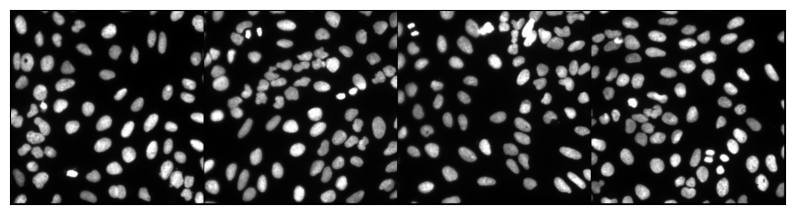

In [83]:
grid = make_grid(batch[:, :1, :, :], figsize=(14, 14))
show(grid)

In [38]:
batch[0, 0]

tensor([[0.3098, 0.3647, 0.4039,  ..., 0.0039, 0.0039, 0.0078],
        [0.2510, 0.3020, 0.3490,  ..., 0.0039, 0.0039, 0.0039],
        [0.1882, 0.2353, 0.2784,  ..., 0.0039, 0.0039, 0.0039],
        ...,
        [0.0118, 0.0118, 0.0118,  ..., 0.0196, 0.0196, 0.0196],
        [0.0157, 0.0157, 0.0157,  ..., 0.0196, 0.0235, 0.0196],
        [0.0118, 0.0157, 0.0118,  ..., 0.0196, 0.0196, 0.0196]])

In [59]:
batch.shape

torch.Size([16, 5, 768, 768])

In [60]:
%timeit transforms.RandomCrop(256)(random_batch).shape

41 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
%timeit _transforms.RandomCrop(256)(random_batch).shape

28.9 µs ± 687 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
trans = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(256),
    ImageNormalization(),
)

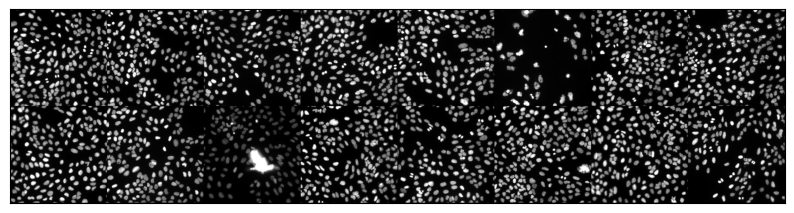

In [84]:
grid = make_grid(batch[:, :1, :, :], figsize=(14, 14))
show(grid)

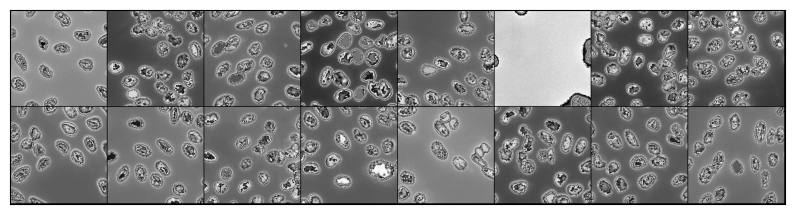

In [87]:
grid = make_grid(trans(batch)[:, :1, :, :], figsize=(14, 14))
show(grid)